In [ ]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import warnings
from scipy.stats import pearsonr
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('stopwords')
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('JOINT_ted_video_transcripts_comments_stats.csv')
print(df.head())

      video_id                                         transcript  \
0  YgAuFqEs6yk     remember watch father raise pistol plead gu...   
1  bNmRr-BYnxA       think give   half humanity ' spend   week...   
2  FVUkKKc3Vvk     work trading floor ' m pretty new graduate ...   
3  8bj0GR34XWc         worry pandemic pretty life play absolut...   
4  eaCrsBtiYA4     public policy wonk investigate datum point ...   

   polarity_neg_transcript  polarity_pos_transcript  polarity_neu_transcript  \
0                    0.133                    0.330                    0.537   
1                    0.194                    0.267                    0.539   
2                    0.111                    0.306                    0.583   
3                    0.135                    0.166                    0.699   
4                    0.200                    0.164                    0.636   

   polarity_compound_transcript  \
0                        0.9996   
1                        0.9980   

In [ ]:
df.shape

(2418, 34)

In [ ]:
df.isnull().sum()

video_id                          0
transcript                        0
polarity_neg_transcript           0
polarity_pos_transcript           0
polarity_neu_transcript           0
polarity_compound_transcript      0
tags                             10
title                            10
publushed_date                   10
comments_count                   24
dislike_count                    10
like_count                       10
views_count                      10
today                            10
days_age                         10
views_per_day                    10
dislike_perc_of_likes            10
success                          10
prime_tag                        10
comments                        440
polarity_neg_comments           440
polarity_pos_comments           440
polarity_neu_comments           440
polarity_compound_comments      440
trust                           440
fear                            440
negative                        440
sadness                     

In [ ]:
import pandas as pd

# Splitting the datetime string by space
splitted = df['publushed_date'].str.split(' ', expand=True)

# Creating columns for date, month, year, hour, minute, and second of the talk
df['date'] = splitted[0]
df['time'] = splitted[1]

# Extracting date components
df['year'] = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.month
df['day'] = pd.to_datetime(df['date']).dt.day

# Extracting time components
df['hour'] = pd.to_datetime(df['time']).dt.hour
df['minute'] = pd.to_datetime(df['time']).dt.minute
df['second'] = pd.to_datetime(df['time']).dt.second

# Dropping the temporary columns 'date' and 'time'
df.drop(['date', 'time'], axis=1, inplace=True)


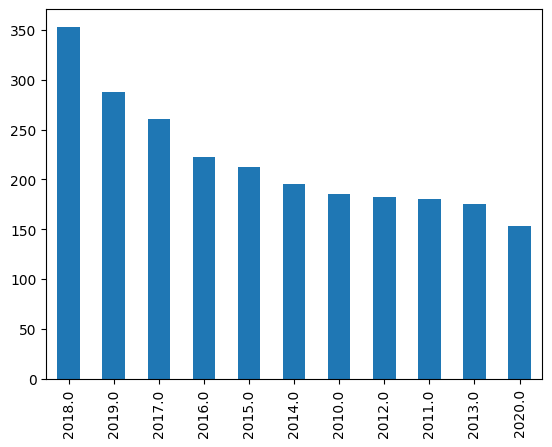

In [ ]:
df['year'].value_counts().plot.bar()
plt.show()

In [ ]:
# Let's combine the title and the details of the talk.
df['details'] = df['title'] + ' ' + df['transcript']
# Removing the unnecessary information
df = df[['details']]
df.dropna(inplace = True)
df.head()

,details
0,"How to co-parent as allies, not adversaries | ..."
1,How to shift your mindset and choose your futu...
2,What's missing from the American immigrant nar...
3,A global pandemic calls for global solutions |...
4,Racism has a cost for everyone | Heather C. Mc...


In [ ]:
# We would like to have a copy of our data for future use.
data = df.copy()

In [ ]:
def remove_stopwords(text):
  stop_words = stopwords.words('english')
  imp_words = []
  # Storing the important words
  for word in str(text).split():
    word = word.lower()
    if word not in stop_words:
      imp_words.append(word)
  output = " ".join(imp_words)
  return output

In [ ]:
df['details'] = df['details'].apply(lambda text: remove_stopwords(text))
df.head()

,details
0,"co-parent allies, adversaries | ebony roberts ..."
1,shift mindset choose future | tom rivett-carna...
2,what's missing american immigrant narrative | ...
3,global pandemic calls global solutions | larry...
4,racism cost everyone | heather c. mcghee publi...


In [ ]:
punctuations_list = string.punctuation
def cleaning_punctuations(text):
    signal = str.maketrans('', '', punctuations_list)
    return text.translate(signal)
df['details'] = df['details'].apply(lambda x: cleaning_punctuations(x))
df.head()

,details
0,coparent allies adversaries ebony roberts sha...
1,shift mindset choose future tom rivettcarnac ...
2,whats missing american immigrant narrative el...
3,global pandemic calls global solutions larry ...
4,racism cost everyone heather c mcghee public ...


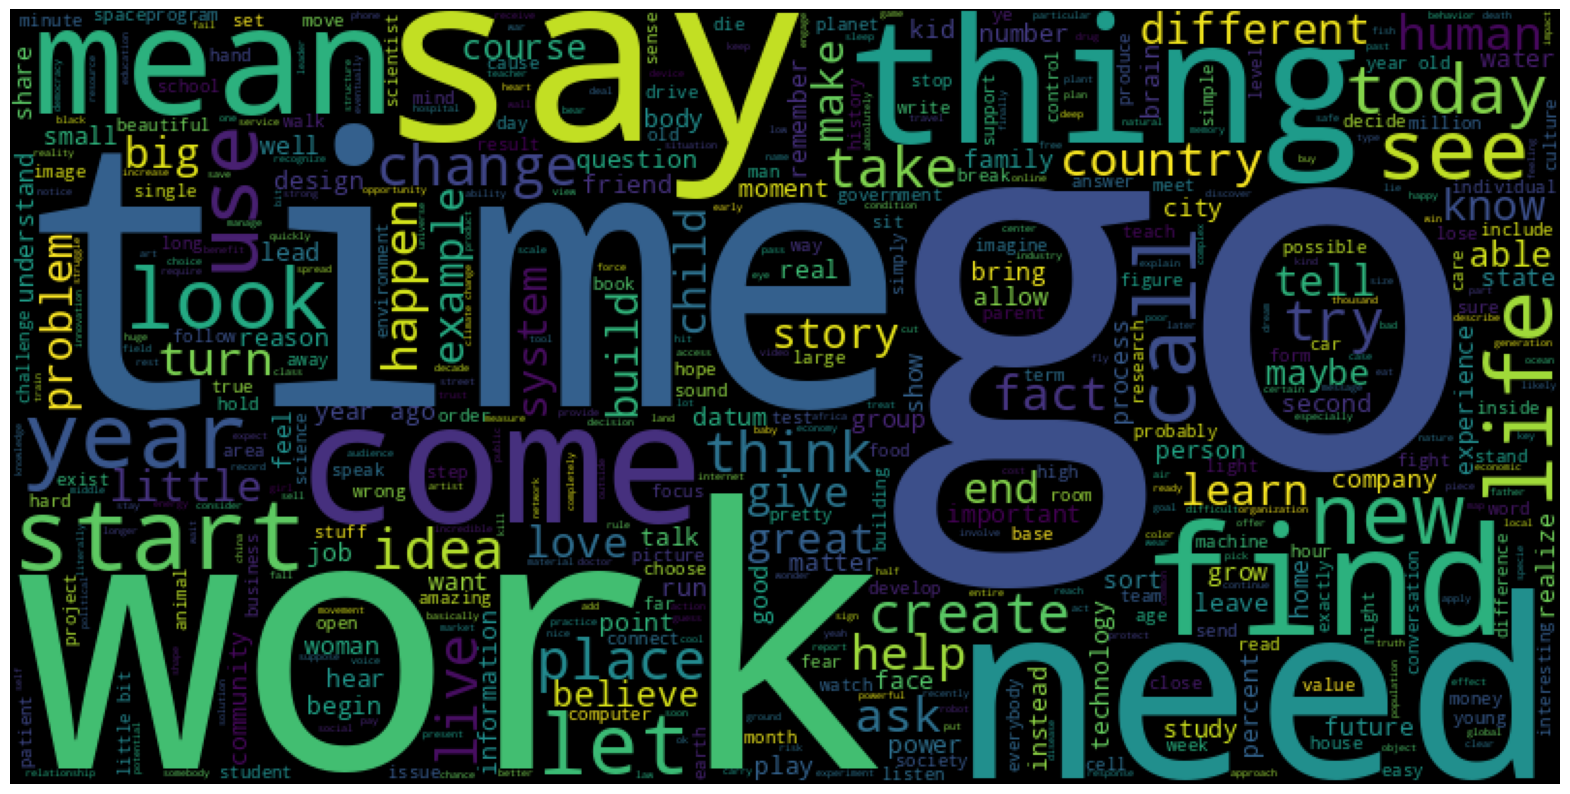

In [ ]:
details_corpus = " ".join(df['details'])
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000,
               width=800,
               height=400).generate(details_corpus)
plt.axis('off')
plt.imshow(wc)
plt.show()

In [ ]:
%%capture
vectorizer = TfidfVectorizer(analyzer = 'word')
vectorizer.fit(df['details'])

In [88]:
def get_similarities(talk_content, data=df):
    # Getting vector for the input talk_content.
    talk_array1 = vectorizer.transform(talk_content).toarray()
    # We will store similarity for each row of the dataset.
    sim = []
    pea = []
    for idx, row in data.iterrows():
        details = row['details']  # Assuming 'transcript' is the correct column name
        # Getting vector for current talk.
        talk_array2 = vectorizer.transform([details]).toarray()
        # Ensure talk_array1 and talk_array2 have the same length
        if len(talk_array1[0]) != len(talk_array2[0]):
            raise ValueError("Talk arrays have different lengths")
        # Calculating cosine similarities
        cos_sim = cosine_similarity(talk_array1, talk_array2)[0][0]
        # Calculating pearson correlation
        pea_sim = pearsonr(talk_array1.squeeze(), talk_array2.squeeze())[0]
        sim.append(cos_sim)
        pea.append(pea_sim)
    return sim, pea


In [89]:
def recommend_talks(talk_content, data=data):
    data['cos_sim'], data['pea_sim'] = get_similarities(talk_content)
    data.sort_values(by=['cos_sim', 'pea_sim'], ascending=[
                     False, False], inplace=True)
    display(data[['details']].head())

In [90]:
talk_content = ['Time Management']
recommend_talks(talk_content)

,details
477,How conscious investors can turn up the heat a...
1038,How to gain control of your free time | Laura ...
2251,Kristina Gjerde: Making law on the high seas ...
410,8 lessons on building a company people enjoy w...
61,Management lessons from Chinese business and p...


In [91]:
talk_content = ['Climate change and impact on the health\
. How can we change this world by reducing carbon footprints?']
recommend_talks(talk_content)

,details
1779,Joel Selanikio: The surprising seeds of a big-...
1298,The moral bias behind your search results | An...
1052,What happens when you have a disease doctors c...
944,The refugee crisis is a test of our character ...
2318,"Peter Molyneux demos Milo, the virtual boy ..."


In [ ]:
import pickle

In [ ]:
filename = 'tedtalks_recommendation.pkl'
pickle.dump(recommend_talks, open(filename, 'wb'))

In [ ]:
# loading the saved model
loaded_model = pickle.load(open('tedtalks_recommendation.pkl', 'rb'))

In [ ]:
for column in df.columns:
  print(column)

main_speaker
details
